# GPT (Small version)

Implement incrementally a small version of the GPT to be trained on Tiny Shakespeare

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1337)
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline

## Read the dataset

In [1]:
with open("./data/tiny-shakespeare/input.txt") as file:
    data = file.read()

len(data)

1115394

In [2]:
data[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [3]:
chars = sorted(list(set(data)))
chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
len(chars)

65

In [5]:
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [6]:
encoded_word = encode('hello world')
decoded_word = decode(encoded_word)
print(encoded_word)
print(decoded_word)

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [11]:
def get_batch(tokens, block_size, batch_size):
    batch = torch.randint(0, len(tokens)-block_size, (batch_size,)) # B dimension array of random indices
    Xb = torch.stack([torch.LongTensor(tokens[i:i+block_size]) for i in batch], dim=0) # Create (B, T) dimension array
    yb = torch.stack([torch.LongTensor(tokens[i+1:i+block_size+1]) for i in batch], dim=0) # Create (B, T) dimension array
    return Xb, yb

In [12]:
@torch.no_grad()
def compute_loss(tokens, block_size, batch_size, model, device):
    loss_values = []
    for _ in range(1000):
        Xb, yb = get_batch(tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        _, loss = model(Xb, yb)
        loss_values.append(loss.item())

    mean_loss = torch.FloatTensor(loss_values).mean().item()
    return mean_loss

In [28]:
def train(train_tokens, val_tokens, model, optimizer, device, block_size, batch_size, n_iters, eval_interval):
    stepi, train_lossi, val_lossi = [], [], []
    
    for i in range(n_iters):
        model.train()
        Xb, yb = get_batch(train_tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        # forward
        _, loss = model(Xb, yb)

        # set grads to zero
        optimizer.zero_grad(set_to_none=True)

        # do backward
        loss.backward()

        # optimizer step
        optimizer.step()

        if i % eval_interval == 0:
            model.eval()
            train_loss = compute_loss(train_tokens, block_size, batch_size, model, device)
            val_loss = compute_loss(val_tokens, block_size, batch_size, model, device)

            stepi.append(i//eval_interval)
            train_lossi.append(train_loss)
            val_lossi.append(val_loss)

            print(f"Step {i}/{n_iters} --> Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        # break

    return stepi, train_lossi, val_lossi

In [16]:
tokens = encode(data)
len(tokens)

1115394

In [17]:
data_size = len(tokens)
split_idx = int(0.8 * data_size)
train_tokens = tokens[:split_idx]
val_tokens = tokens[split_idx:]
len(train_tokens), len(val_tokens)

(892315, 223079)

## Iteration 1: Add a self attention and a linear layer for transformation

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, block_size, channel_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.k_project = nn.Linear(channel_dim, head_dim, bias=False) # [B,T,C] --> [B,T,H]
        self.q_project = nn.Linear(channel_dim, head_dim, bias=False) # [B,T,C] --> [B,T,H]
        self.v_project = nn.Linear(channel_dim, head_dim, bias=False) # [B,T,C] --> [B,T,H]
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # [T,T]

    def forward(self, x):
        B, T, C = x.shape 
        # Step 1: Get the keys, queries and values
        k = self.k_project(x) # [B,T,C] -> [B,T,H]
        q = self.q_project(x)
        v = self.v_project(x)

        # Step 2: Get the activations
        wei = q @ k.transpose(-2, -1) * (self.head_dim**-0.5) # [B,T,H] * [B,H,T] --> [B,T,T], divide by H**0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # [B,T,T]
        wei = torch.softmax(wei, dim=-1) #[B,T,T]
        
        # Now get the final activations after applying attention
        activations = wei @ v # [B,T,T] @ [B,T,H] --> [B,T,H]

        return activations

In [50]:
class SelfAttentionAddedLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, head_dim):
        super().__init__()
        self.block_size = block_size
        self.token_emb_table = nn.Embedding(vocab_size, emb_dim)
        self.sa = SelfAttention(block_size, emb_dim, head_dim)
        self.final_linear_layer = nn.Linear(head_dim, vocab_size)
        print(f"Number of params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, idx, targets=None):
        embs = self.token_emb_table(idx) # embs shape: [B,T,C]
        sa_embs = self.sa(embs) # [B,T,C] --> [B,T,H]
        logits = self.final_linear_layer(sa_embs) # [B,T,H] --> [B,T,V]
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, device, max_tokens=1000):
        with torch.no_grad():
            curr_context, curr_str = [0], "\n"

            for _ in range(max_tokens):
                inp_context = torch.LongTensor(curr_context[-self.block_size:]).view(1, -1) # [B=1, T]
                inp_context = inp_context.to(device)
                logits, _ = self(inp_context) # [B, T, C]
                B, T, V = logits.shape
                logits = logits.view(B*T, V)
                probs = torch.softmax(logits, dim=1)
                next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True)[-1].item()
                curr_str += itos[next_char_idx]
                curr_context.append(next_char_idx)

            return curr_str

In [41]:
vocab_size = len(stoi)
batch_size = 32
block_size = 8
emb_dim = 32
head_dim = 32
n_iters = 50000
eval_interval = n_iters//20
lr = 1e-3
device = ('cuda' if torch.cuda.is_available()
          else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
          else 'cpu')

In [42]:
sa_lm = SelfAttentionAddedLM(vocab_size=vocab_size, emb_dim=emb_dim,\
                             block_size=block_size, head_dim=head_dim)
sa_lm = sa_lm.to(device)

Number of params: 7297


In [43]:
optimizer = optim.AdamW(sa_lm.parameters(), lr=lr)

In [44]:
stepi, train_lossi, val_lossi = train(train_tokens, val_tokens,\
       sa_lm, optimizer, device, block_size, batch_size, n_iters, eval_interval)

Step 0/50000 --> Train: 4.1632 | Val: 4.1644
Step 2500/50000 --> Train: 2.4749 | Val: 2.5027
Step 5000/50000 --> Train: 2.4379 | Val: 2.4765
Step 7500/50000 --> Train: 2.4190 | Val: 2.4597
Step 10000/50000 --> Train: 2.4076 | Val: 2.4505
Step 12500/50000 --> Train: 2.4020 | Val: 2.4545
Step 15000/50000 --> Train: 2.4027 | Val: 2.4526
Step 17500/50000 --> Train: 2.3993 | Val: 2.4461
Step 20000/50000 --> Train: 2.3944 | Val: 2.4459
Step 22500/50000 --> Train: 2.3922 | Val: 2.4472
Step 25000/50000 --> Train: 2.3981 | Val: 2.4447
Step 27500/50000 --> Train: 2.3934 | Val: 2.4410
Step 30000/50000 --> Train: 2.3906 | Val: 2.4446
Step 32500/50000 --> Train: 2.3868 | Val: 2.4457
Step 35000/50000 --> Train: 2.3873 | Val: 2.4444
Step 37500/50000 --> Train: 2.3846 | Val: 2.4486
Step 40000/50000 --> Train: 2.3877 | Val: 2.4433
Step 42500/50000 --> Train: 2.3845 | Val: 2.4414
Step 45000/50000 --> Train: 2.3893 | Val: 2.4414
Step 47500/50000 --> Train: 2.3878 | Val: 2.4386


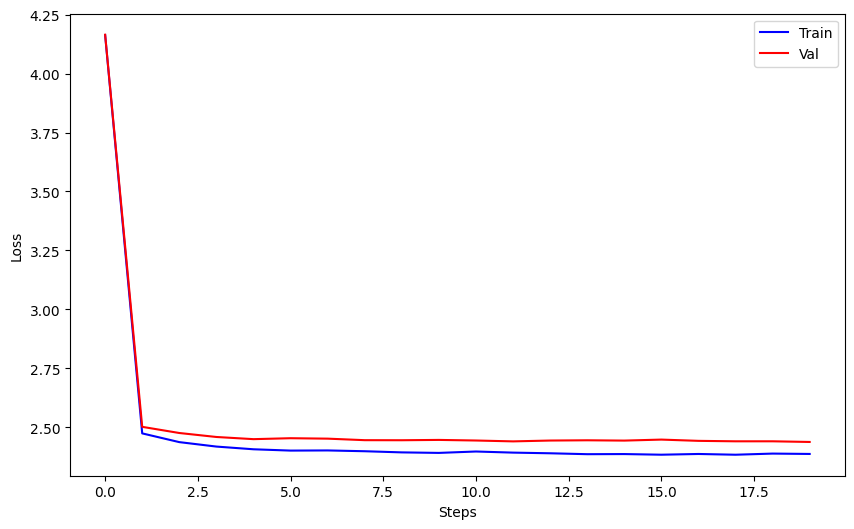

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(stepi, train_lossi, label='Train', color='blue')
plt.plot(stepi, val_lossi, label='Val', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
display(Markdown(sa_lm.generate(device)))


Ford mir; ar jooun a tewndinoerd day a be wntile n gor Cathe y, hare doud at lf 'lladwed is klingoburorn thtous hicat ntreloll ld bedeshe
Comalim deasher.

Burd.
He Cllafin ne?
Ner, selple t I sousind
I t'Dut on my
I'tilay n, famous, t, ary theesabe houbllt, warfff cy masun t'sthed s fourmelf l, sofanert ye wo mprfray peaveatith atoo cesst,
I he tisidstoo or, brd
Foairathigus.
Nons, histerey, d

Wet nofamateop othimaseay rs sewoby MENarace?
Asllod:
Ofseeail belindeno?
Of heaivele tts, mis wisth Meenthat tos.
f Viotharng.

LONUCELomon t: latashou s te esste y Mar, sdothind pe
Frireretr w oyoueseret silthe lot wo ato-dd Rofro a sofalecchingir cay itfow leedlir s stsis nd thet thees atifllin?
No horsathe my ge ppuohid Yofowhourdeonme n, the: methe he be cantu n
Yoth thouour w'd ctedels rr in shaghot mou.

BICROK:
Dut IF Saneavyo
S g in?
Plchy nghit han:
Tow'Lols o tha do tilu.
'?
PHenome on.

HAE LOXNENROMEERDN:
Iist's
Theis hothurnouno frnd hed, mes me sl oubes.
Farsen che wat, allothon 

## Iteration 2: Add position embs

In [61]:
class SelfAttentionAddedLMWithPos(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, head_dim):
        super().__init__()
        self.block_size = block_size
        self.token_emb_table = nn.Embedding(vocab_size, emb_dim)
        self.position_emb_table = nn.Embedding(block_size, emb_dim)
        self.sa = SelfAttention(block_size, emb_dim, head_dim)
        self.final_linear_layer = nn.Linear(head_dim, vocab_size)
        print(f"Number of params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_embs = self.token_emb_table(idx) # embs shape: [B,T,C]
        pos_embs = self.position_emb_table(torch.arange(T).to(device)) # [T,C]
        inp_embs = token_embs + pos_embs
        sa_embs = self.sa(inp_embs) # [B,T,C] --> [B,T,H]
        logits = self.final_linear_layer(sa_embs) # [B,T,H] --> [B,T,V]
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, device, max_tokens=1000):
        with torch.no_grad():
            curr_context, curr_str = [0], "\n"

            for _ in range(max_tokens):
                inp_context = torch.LongTensor(curr_context[-self.block_size:]).view(1, -1) # [B=1, T]
                inp_context = inp_context.to(device)
                logits, _ = self(inp_context) # [B, T, C]
                B, T, V = logits.shape
                logits = logits.view(B*T, V)
                probs = torch.softmax(logits, dim=1)
                next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True)[-1].item()
                curr_str += itos[next_char_idx]
                curr_context.append(next_char_idx)

            return curr_str

In [62]:
model = SelfAttentionAddedLMWithPos(vocab_size=vocab_size, emb_dim=emb_dim,\
                             block_size=block_size, head_dim=head_dim)
model = model.to(device)

Number of params: 7553


In [63]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [64]:
stepi, train_lossi, val_lossi = train(train_tokens, val_tokens,\
       model, optimizer, device, block_size, batch_size, n_iters, eval_interval)

Step 0/50000 --> Train: 4.2892 | Val: 4.2867
Step 2500/50000 --> Train: 2.4290 | Val: 2.4561
Step 5000/50000 --> Train: 2.3864 | Val: 2.4158
Step 7500/50000 --> Train: 2.3621 | Val: 2.4054
Step 10000/50000 --> Train: 2.3541 | Val: 2.3891
Step 12500/50000 --> Train: 2.3411 | Val: 2.3935
Step 15000/50000 --> Train: 2.3357 | Val: 2.3962
Step 17500/50000 --> Train: 2.3323 | Val: 2.3821
Step 20000/50000 --> Train: 2.3281 | Val: 2.3803
Step 22500/50000 --> Train: 2.3257 | Val: 2.3874
Step 25000/50000 --> Train: 2.3211 | Val: 2.3739
Step 27500/50000 --> Train: 2.3241 | Val: 2.3811
Step 30000/50000 --> Train: 2.3260 | Val: 2.3759
Step 32500/50000 --> Train: 2.3212 | Val: 2.3790
Step 35000/50000 --> Train: 2.3145 | Val: 2.3767
Step 37500/50000 --> Train: 2.3174 | Val: 2.3792
Step 40000/50000 --> Train: 2.3148 | Val: 2.3723
Step 42500/50000 --> Train: 2.3132 | Val: 2.3767
Step 45000/50000 --> Train: 2.3148 | Val: 2.3756
Step 47500/50000 --> Train: 2.3139 | Val: 2.3788


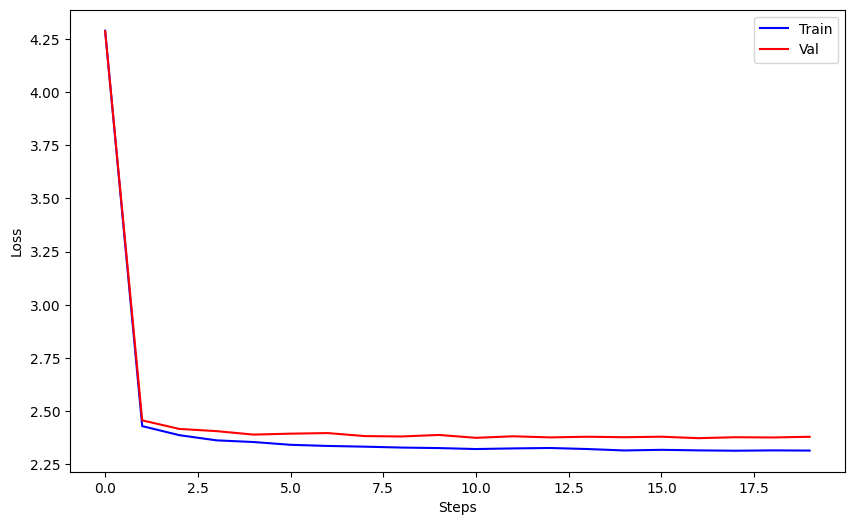

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(stepi, train_lossi, label='Train', color='blue')
plt.plot(stepi, val_lossi, label='Val', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
display(Markdown(model.generate(device)))


Ing'ls wanonater es the morindivedarcorue crairotowexcoura cre hey ancovesinrtes cond oofof thal wastordus, a ffown carr
Dy Y Com, a toowomearbe:
A arseiquure wincthis win im hang theale,
in hay,
A I ofrris us, st hea we dratire,
Wet lere yer.

Thim! fre the.


KINENEO:
What, ty
WI walld lly my,
Y'd, ma sizea lore aner yer em ireler owel kes,
Thy ushatis,
York edileaimaru Wiatr he le onses toienee,
Seat ietn nce nothorgetazespith thy,
Arachilo ancus aly?

Fonode sath facr tharieght ders ki, farme.

ADI:
is lof ceser, on sn
Andiorert ple da;
voticre thich wimee ye I sws st indy
Loutstus oto goted cyor otien I thalive fis ng berast fadse ble at ubrer
bun spapoprrnd Ravepiluthacpal fot, hat wamathar it me:
Narde,
c'lde iror pech by mas en, teamme,
Thot wenee kdentose wereet herth willofo sofrods spot fewin, pwisofor,
mat. Couthe sout yer, wen.

SYOFRY outhairdant ouparn, anl.
DI wiree tay ist cows fly,
Coke pd;
And bes ays win:
Tho man: yo wes hmosaty:
A asis! the: bive gh my sccort a tha

## Iteration 2: Add a FFN

In [67]:
class SelfAttentionAddedLMWithPosAndFFN(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, head_dim):
        super().__init__()
        self.block_size = block_size
        self.token_emb_table = nn.Embedding(vocab_size, emb_dim)
        self.position_emb_table = nn.Embedding(block_size, emb_dim)
        self.sa = SelfAttention(block_size, emb_dim, head_dim)
        self.ffn = nn.Sequential(
            nn.Linear(head_dim, 4 * head_dim),
            nn.ReLU(),
            nn.Linear(4 * head_dim, head_dim)
        )
        self.final_linear_layer = nn.Linear(head_dim, vocab_size)
        print(f"Number of params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_embs = self.token_emb_table(idx) # embs shape: [B,T,C]
        pos_embs = self.position_emb_table(torch.arange(T).to(device)) # [T,C]
        inp_embs = token_embs + pos_embs
        sa_embs = self.sa(inp_embs) # [B,T,C] --> [B,T,H]
        ffn_embs = self.ffn(sa_embs)# [B,T,H] --> [B,T,H]
        logits = self.final_linear_layer(ffn_embs) # [B,T,H] --> [B,T,V]
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, device, max_tokens=1000):
        with torch.no_grad():
            curr_context, curr_str = [0], "\n"

            for _ in range(max_tokens):
                inp_context = torch.LongTensor(curr_context[-self.block_size:]).view(1, -1) # [B=1, T]
                inp_context = inp_context.to(device)
                logits, _ = self(inp_context) # [B, T, C]
                B, T, V = logits.shape
                logits = logits.view(B*T, V)
                probs = torch.softmax(logits, dim=1)
                next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True)[-1].item()
                curr_str += itos[next_char_idx]
                curr_context.append(next_char_idx)

            return curr_str

In [68]:
model = SelfAttentionAddedLMWithPosAndFFN(vocab_size=vocab_size, emb_dim=emb_dim,\
                             block_size=block_size, head_dim=head_dim)
model = model.to(device)

Number of params: 15905


In [69]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

In [70]:
stepi, train_lossi, val_lossi = train(train_tokens, val_tokens,\
       model, optimizer, device, block_size, batch_size, n_iters, eval_interval)

Step 0/50000 --> Train: 4.2068 | Val: 4.2067
Step 2500/50000 --> Train: 2.5103 | Val: 2.5336
Step 5000/50000 --> Train: 2.4006 | Val: 2.4317
Step 7500/50000 --> Train: 2.3475 | Val: 2.3811
Step 10000/50000 --> Train: 2.3160 | Val: 2.3556
Step 12500/50000 --> Train: 2.2855 | Val: 2.3261
Step 15000/50000 --> Train: 2.2673 | Val: 2.3102
Step 17500/50000 --> Train: 2.2449 | Val: 2.2947
Step 20000/50000 --> Train: 2.2277 | Val: 2.2796
Step 22500/50000 --> Train: 2.2069 | Val: 2.2583
Step 25000/50000 --> Train: 2.1964 | Val: 2.2497
Step 27500/50000 --> Train: 2.1830 | Val: 2.2351
Step 30000/50000 --> Train: 2.1760 | Val: 2.2344
Step 32500/50000 --> Train: 2.1606 | Val: 2.2219
Step 35000/50000 --> Train: 2.1519 | Val: 2.2118
Step 37500/50000 --> Train: 2.1427 | Val: 2.2079
Step 40000/50000 --> Train: 2.1387 | Val: 2.2074
Step 42500/50000 --> Train: 2.1331 | Val: 2.2006
Step 45000/50000 --> Train: 2.1224 | Val: 2.2021
Step 47500/50000 --> Train: 2.1143 | Val: 2.1869


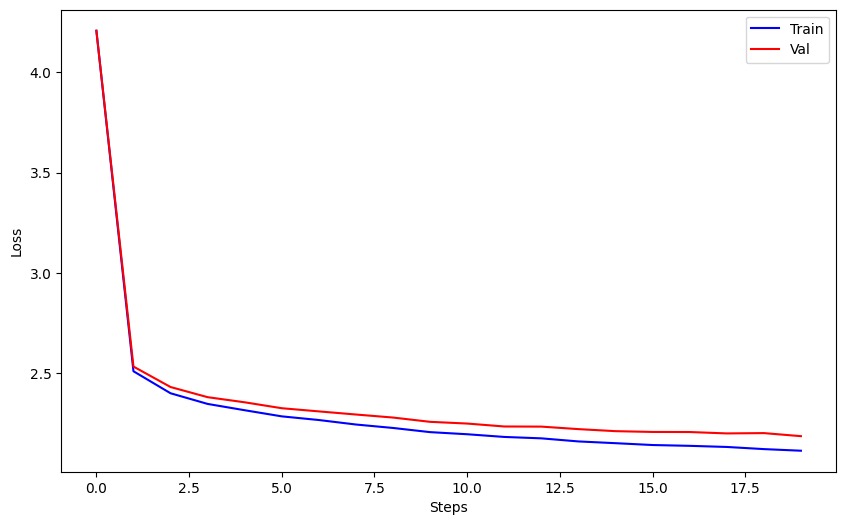

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(stepi, train_lossi, label='Train', color='blue')
plt.plot(stepi, val_lossi, label='Val', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
display(Markdown(model.generate(device)))


WIFLEOMO:
The dond fur heagut wonake alnen.

FRY LANDWARD Prunly.

UNLEING:
So you af homepim bef but bace decre a am on 'thermeed and their ther my to. Whan then thy thiveed the cire, in tevim lout cher:
Thit 's hlous, be an nome.

WARD OF I mut nequary ma?

Thy suremand gooss:
Sauld stre his food you slefor him comil hat st in brod of doune is bood andes; froth bef bef.

KINGHANG LANGHARD ut abawer son, bropell isoucstwers.
Swit coppeok ing with ouldewen, the is andend boe fall, youn andughte, thy tow an no low,
Congtath ford?

RY Heest
Pried?

QUEER:
Bequelulad of diospe you warpoo:-mom ear with with of mee crer?

ENV:
Ealtes
U
MPORDIUS:
And hipe fo.

KINCETOLINCES:
And's my!

FERWIAULLINBRONE:
Sthers wer foot amst of fore; to lalt.


KING LERY:
Kay! Te envines san tingue is to to sajend begock ip welice;
Tpere,
And you ree gou wo-will spiellall hame, to frow shice, heat let dout Borturst susuet is god lourboin, ard tharder wory wiceld,
Do cowse, I put amy you ary shadn:
She yough s